![logo](./img/LogoLine_horizon_CAMS.png)

<br>

# CAMS Atmospheric Composition Data Access and Analysis Tutorial
In this tutorial we will access and view data from the Copernicus Atmosphere Monitoring Service (CAMS). The tutorial includes the following steps:

1. **About this tutorial**: Some instructions on how to run this tutorial.

2. **Register with ADS**: Register with the Atmosphere Data Store (ADS) of CAMS, and obtain an Application Programming Interface (API) key to enable automatic download within Jupyter.

3. **Download CAMS global atmospheric composition data and view animation**: Download CAMS global atmospheric composition forecasts data from the ADS. View an animation of total Aerosol Optical Depth (AOD) at 550nm for the beginning of August 2021 over the Northern Hemisphere.

4. **Compare atmospheric composition variables**: Compare total AOD with organic matter AOD and dust AOD to obtain more information about the possible source of aerosols.

5. **Download and view CAMS global reanalysis (EAC4) monthly averaged fields**: Download EAC global Carbon Monoxide data for August 2021 at all pressure levels. Calculate CO climatology and view data at different pressure levels.

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/CAMS_atmospheric-composition.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/CAMS_atmospheric-composition.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/CAMS_atmospheric-composition.ipynb)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/CAMS_atmospheric-composition.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install [Xarray](http://xarray.pydata.org/en/stable/) for working with multidimensional data in netcdf files, and the ADS API (`pip install cdsapi`) for downloading data programatically from the ADS.

## Data Access

Whether you choose to run this notebook in the cloud, or install it on your own environment, you will need first to carry-out the steps outlined in this section to ensure you have access to CAMS data programmatically through the API.

### Register with ADS

To register with the ADS visit https://ads.atmosphere.copernicus.eu and select **"Login/Register"**

![logo](./img/ADS_login.png)

### Obtain ADS API key

To obtain data programmatically from the ADS, you will need an API Key. This can be found in the page https://ads.atmosphere.copernicus.eu/api-how-to. Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS (as described above).

Once you have an API Key for the ADS, insert it into the cell below, i.e. substitute `ADS_API_KEY` with your ADS API key, then click "Run", or select Shift+Enter to run your first cell!

In [1]:
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

# enter your ADS authentication key:
ADS_KEY = "ADS_API_KEY"

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [1]:
DATADIR = './'

### Install API and other packages

We will now install the API that will allow you to download CAMS data programmatically. Note the exclamation mark! This means the line of code will run as a shell command rather than a notebook command (Using a command without ! in the terminal is the same as using the command with ! in a Jupyter notebook).

In [2]:
!pip install cdsapi

We may also have to install imageio, if not already installed. This is a Python library that provides an easy interface to read and write a wide range of image data, including animated images.

In [ ]:
!pip install imageio

### Import libraries

We now need to import the libraries needed for our analyses:

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import imageio

# Others
from zipfile import ZipFile
from IPython.display import clear_output
from time import sleep

## CAMS global atmospheric composition data

### Search for data on the ADS

To search for data, visit the ADS website: https://ads.atmosphere.copernicus.eu To facilitate your search you can use keywords, or apply various filters.

The data we are going to use in this part of the exercise is the CAMS global atmospheric composition forecasts data. Using the filters, or keywords, search for the dataset `CAMS global atmospheric composition forecasts`.

![logo](./img/ADS_search_and_result.png)

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Variables (Single level): `Dust aerosol optical depth at 550nm`
- Variables (Single level): `Organic matter aerosol optical depth at 550nm` 
- Variables (Single level): `Total aerosol optical depth at 550nm`
- Date: Start: `2021-08-01`, End: `2021-08-08`
- Time: `00:00`, `12:00` (default)
- Leadtime hour: `0` (only analysis)
- Type: `Forecast` (default)
- Area: Restricted area: `North: 80`, `East: 150`, `South: 25`, `West: -150` 
- Format: `Zipped netCDF (experimental)`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

**Important!** At the end of the data download page, you will be asked to **accept the terms and conditions**. You will only be able to download data once these have been accepted - this only needs to be done once.

### Download data using ADS API

Having copied the API request into the cell below, running this will retrieve and download the data you requested.

In [5]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': [
            'dust_aerosol_optical_depth_550nm', 'organic_matter_aerosol_optical_depth_550nm', 'total_aerosol_optical_depth_550nm',
        ],
        'date': '2021-08-01/2021-08-08',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'type': 'forecast',
        'area': [
            90, -180, 0,
            180,
        ],
        'format': 'netcdf_zip',
    },
    f'{DATADIR}2021-08_NHemisphere_AQ.zip')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-02-11 13:54:52,512 INFO Welcome to the CDS
2022-02-11 13:54:52,513 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-02-11 13:54:52,575 INFO Request is completed
2022-02-11 13:54:52,582 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-

Result(content_length=19532728,content_type=application/zip,location=https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data8/adaptor.mars_constrained.external-1638795808.0561106-26035-18-039bb53f-1382-4555-bf74-6921b5d8ce61.zip)

### Read data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for gridded (array-based) scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

First we extract the downloaded zip file:

In [9]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}2021-08_NHemisphere_AQ.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}2021-08_NHemisphere_AQ/')

For convenience, we create a variable with the name of our downloaded file:

In [3]:
fn = f'{DATADIR}2021-08_NHemisphere_AQ/data.nc'

Now we can read the data into an Xarray dataset:

In [4]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)

Let's see how this looks by querying our newly created Xarray dataset ...

In [5]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 226, time: 16)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... 1.2 0.8 0.4 -2.033e-13
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T12:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-06 13:03:27 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

We see that the dataset has three variables. Selecting the "show/hide attributes" icons reveals their names: **"omaod550"** is "Organic Matter Aerosol Optical Depth at 550nm", **"aod550"** is "Total Aerosol Optical Depth at 550nm" and **"duaod550"** is "Dust Aerosol Optical Depth at 550nm".
The dataset also has three coordinates of **longitude**, **latitude** and **time**.

We will now look more carefully at the "Total Aerosol Optical Depth at 550nm" dataset.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **omaod550** data easier, we convert in into an Xarray data array.

In [6]:
# Create Xarray Data Array
da = ds['omaod550']

In [7]:
da

<xarray.DataArray 'omaod550' (time: 16, latitude: 226, longitude: 900)>
[3254400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... 1.2 0.8 0.4 -2.033e-13
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T12:00:00
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

We will now view this data, initially for just one time step.

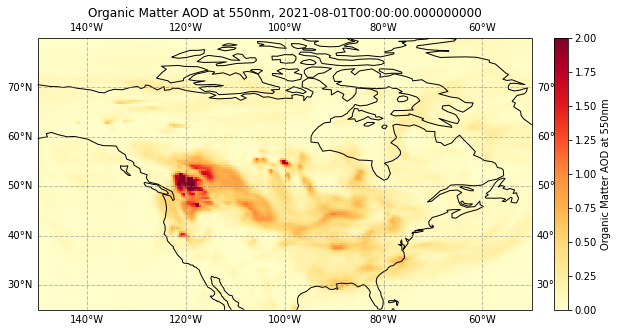

In [15]:
time_step = 0

# create the figure panel 
fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size

# create the map using the cartopy PlateCarree projection
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Specify geographical extent
ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) 

# Add lat/lon grid
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Set figure title
ax.set_title(f'Organic Matter AOD at 550nm, {da.time[time_step].values}', fontsize=12) 

# Plot the data
im = plt.pcolormesh(da.longitude, da.latitude, da[time_step,:,:], cmap='YlOrRd', vmin=0, vmax=2) 

# Add coastlines
ax.coastlines(color='black') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04) 

# Define the colourbar label
cbar.set_label('Organic Matter AOD at 550nm') 

# Save the figure
fig.savefig(f'{DATADIR}OrganicMatterAOD_NHem_2021-08-01_map.png')

To visualise the temporal dimension of this data we will create an animation, with each frame corresponding to a time step. These include 00:00 and 12:00 at each day from 1 to 8 August.

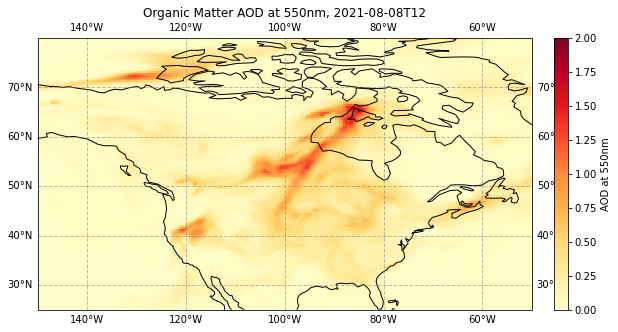

In [16]:
filenames = [] # Define an empty list of filenames
n = da.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
    ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) # Specify geographical extent
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Organic Matter AOD at 550nm, {str(da.time[i].values)[:-16]}', fontsize=12) # Set figure title
    im = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data, iterating over time
    ax.coastlines(color='black') # Add coastlines
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('AOD at 550nm') # Define the colourbar label
    filename = f'{DATADIR}OMAOD_{str(da.time[i].values)[:-16]}.png' # Define a filename for each frame, in PNG format
    fig.savefig(filename) # Save the frame as a PNG file
    filenames.append(filename) # Append the frame to a list, to later create an animated gif
    plt.show() # Display the figure
    sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation

In [18]:
# Save the animation as an animated GIF

with imageio.get_writer(f'{DATADIR}OMAOD_Animated.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

The animation clearly shows the high values of total aerosol optical depth which appear to originate from the many different wildfires burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

The animation also shows these high values crossing the continent to the east coast where it still affects local air quality.

### Change colormap

One more step we will make is to change the colormap of the animation to that commonly used for CAMS products. To do this, we run the code below, then in the animation code above, replace the `cmap='YlOrRd'`, which is one of the default colormaps of Matplotlib, with `cmap=camscmp`, which is the custom colormap below. After this we can re-run the animation with a nice CAMS colormap :)

In [8]:
# This code is just to create a colormap similar to that used in CAMS products.

from matplotlib.colors import ListedColormap

matrix = np.array([[256, 256, 256],
                   [210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])
n = 17 # Multiplication number

cams = np.ones((253, 4)) # Initial empty colormap, to be filled by the colours in 'matrix'.

# This loop fills in the empty 'cams' colormap with each of the 15 colours in 'matrix'
# multiplied by 'n'. Each colour is divided by 256 to normalise from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[(i*n):((i+1)*n),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final colormap is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colormap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

## Compare atmospheric composition variables

We will now try to understand what may be contributing to the total AOD values we have observed in the animation above. We will view and compare the total AOD with the organic matter AOD and dust AOD, for one time step. We will also extend the range to include the entire northern hemisphere.

In [9]:
variables = list(ds.keys())
variables

['omaod550', 'aod550', 'duaod550']

Switch the order of variables to make total AOD (aod550) appear first. This is so that when we iteratively plot the variables (below), total AOD appears first in the list. This enables easier comparison of total AOD with the constituent variables of organic matter and dust AOD.

In [10]:
variables[0], variables[1] = variables[1], variables[0]

In [11]:
variables

['aod550', 'omaod550', 'duaod550']

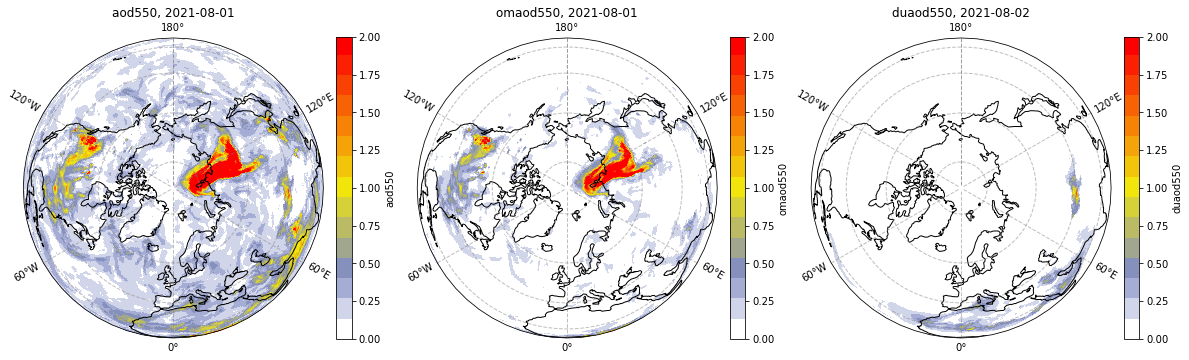

In [12]:
fig, axs = plt.subplots(1, 3, figsize = (20, 10), subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

for i in range(3):
    da = ds[variables[i]]
    axs[i].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    axs[i].set_title(f'{variables[i]}, {str(da.time[i].values)[:-19]}', fontsize=12) # Set figure title
    im = axs[i].pcolormesh(da.longitude, da.latitude, da[0,:,:],
                            transform = ccrs.PlateCarree(), cmap=camscmp, vmin=0, vmax=2)
    axs[i].coastlines(color='black') # Add coastlines
    cbar = fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label(variables[i]) # Define the colourbar label

plt.show() # Display the figure
fig.savefig(f'{DATADIR}AOD_NHem.png') # Save the figure

We can see that the high values of AOD seem to be mainly due to organic matter in North America and Siberia, which saw many wildfire activity in this period, while further south we can see a dust contribution.

## CAMS global reanalysis (EAC4) monthly averaged fields

In this part of the tutorial we will look at another CAMS dataset, the fourth generation ECMWF global reanalysis of atmospheric composition (EAC4). Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using a model of the atmosphere based on the laws of physics and chemistry.

We will use the monthly averaged version of this data to analyse August climatology of the distribution of Carbon Monoxide in the Northern Hemisphere at different vertical layers in the atmosphere.

This dataset is listed in the ADS as `CAMS global reanalysis (EAC4) monthly averaged fields`. Search for this dataset using the filters, or keywords.

The API request below shows the download parameters that we will select:

In [24]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-global-reanalysis-eac4-monthly',
    {
        'variable': 'carbon_monoxide',
        'pressure_level': [
            '100', '150', '200',
            '250', '300', '400',
            '500', '600', '700',
            '800', '850', '900',
            '925', '950', '1000',
        ],
        'model_level': '60',
        'year': [
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': '08',
        'product_type': 'monthly_mean',
        'format': 'netcdf',
        'area': [
            90, -180, 0,
            180,
        ],
    },
    f'{DATADIR}EAC4_AugClim_CO.zip')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-02-11 14:01:00,531 INFO Welcome to the CDS
2022-02-11 14:01:00,532 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-02-11 14:01:00,643 INFO Request is completed
2022-02-11 14:01:00,654 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache

Result(content_length=33461782,content_type=application/zip,location=https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data6/adaptor.mars.internal-1637880838.2016644-31893-9-36c5d906-eee0-44bd-9ad1-663c34fae020.zip)

Extract the file, open it as an Xarray dataset, and inspect the contents:

In [25]:
with ZipFile(f'{DATADIR}EAC4_AugClim_CO.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}EAC4_AugClim_CO/')

In [13]:
fn = f'{DATADIR}EAC4_AugClim_CO/levtype_pl.nc'
ds_co = xr.open_dataset(fn)
ds_co

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 121, level: 15, time: 18)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 2.25 1.5 0.75 0.0
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2003-08-01 2004-08-01 ... 2020-08-01
Data variables:
    co         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-25 22:53:57 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

Note that the data includes monthly averaged CO in every August from 2003 to 2020, for the Northern Hemisphere.

Let's create an Xarray Data Array for the variable CO to faciliate further processing.

In [14]:
da_co = ds_co['co']

### Calculate climatology for August

We will now create the climatology for August by taking the mean of all years.

In [15]:
clim = da_co.mean("time")

### Create meridional mean plot
To visualise the August CO climatology as a function of longitude and altitude, we will create a meridional mean plot. To create such a two dimensional plot we will need to average over the latitudinal axis.

A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes. 

First, we calculate weights as a funtion of the cosine of the latitude, then we apply these weights to the data array with the xarray function `weighted()`:

In [16]:
weights = np.cos(np.deg2rad(clim.latitude))
weights.name = "weights"
clim_weighted = clim.weighted(weights)

The next step is then to compute the mean across the latitude dimension of the weighted data array:

In [17]:
# Average (mean) over the latitudinal axis
clim_MMP = clim_weighted.mean(dim="latitude")

In [18]:
clim_MMP

<xarray.DataArray 'co' (level: 15, longitude: 480)>
array([[3.7636351e-08, 3.7613120e-08, 3.7594834e-08, ..., 3.7727435e-08,
        3.7694573e-08, 3.7667284e-08],
       [5.1665104e-08, 5.1565820e-08, 5.1470167e-08, ..., 5.2007980e-08,
        5.1893519e-08, 5.1769817e-08],
       [6.0400083e-08, 6.0323011e-08, 6.0247352e-08, ..., 6.0686837e-08,
        6.0596612e-08, 6.0497200e-08],
       ...,
       [7.5388236e-08, 7.5252053e-08, 7.5132576e-08, ..., 7.5867327e-08,
        7.5752745e-08, 7.5576835e-08],
       [7.5198876e-08, 7.5047538e-08, 7.4924365e-08, ..., 7.5671807e-08,
        7.5546851e-08, 7.5373151e-08],
       [7.5109575e-08, 7.4985444e-08, 7.4866882e-08, ..., 7.5554262e-08,
        7.5437178e-08, 7.5261070e-08]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000

Now we can plot and visualise our data. 

C:\Users\cxcs\AppData\Local\Temp/ipykernel_18436/2673752635.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(clim_MMP.longitude, y, clim_MMP, cmap=camscmp)


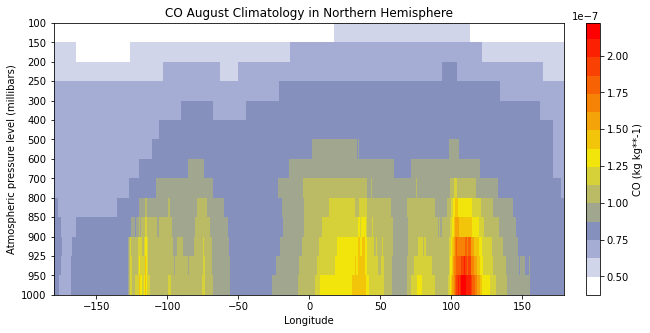

In [19]:
# The y axis (pressure levels) is a non-linear scale.
# To ensure equal spacing between the values, we create a regular scale.
y = np.arange(clim_MMP.level.shape[0])+1
y = y[::-1]

# Define the figure and specify size
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1,1,1)

# Set x and y axis tickmarks, labels and figure title
ax.yaxis.set_ticks(y)
ax.yaxis.set_ticklabels(clim_MMP.level.values)
ax.set_xlabel('Longitude')
ax.set_ylabel('Atmospheric pressure level (millibars)')
ax.set_title('CO August Climatology in Northern Hemisphere', fontsize=12)

# As the presure levels (25) are much less than the longitudes (480),
# we need to ensure the plot fits into the size of the figure.
ax.set_aspect('auto')

# Plot the figure and specify a colourbar
im = plt.pcolormesh(clim_MMP.longitude, y, clim_MMP, cmap=camscmp)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('CO (kg kg**-1)')

fig.savefig(f'{DATADIR}CO_NHem_Aug_clim.png')